In [ ]:
import os
import shutil
from pathlib import Path

import pandas as pd
from rdkit import Chem

from validation_utils import (
    get_inchikey_from_smiles,
    get_pachqa_structures,
    get_rmsd_between_two_molecules,
)

In [ ]:
# path to https://gitlab.com/porannegroup/compas
COMPAS_SOURCE_FOLDER = Path("compas").absolute()

# path to folder with props.csv
PACHQA_SOURCE_FOLDER = Path("../property_parsing/").absolute()

# path to PACHQA structures
PACHQA_STRUCTURES_SOURCE_FOLDER = Path("data").absolute()

# output files will be writen here
TMP_DIR = Path("tmp_compas/").absolute()

In [ ]:
if not TMP_DIR.exists():
    os.makedirs(TMP_DIR)

## Reading PACHQA data

In [ ]:
pachqa_data = pd.read_csv(Path(PACHQA_SOURCE_FOLDER, "props.csv"))
pachqa_data = pachqa_data[pachqa_data.level == "xtb2"]
pachqa_inchikeys = set(pachqa_data.key)

## Reading COMPAS data and merging molecules by InChIKey

In [ ]:
PUBLIC_NAMES = {
    "compas-1x.csv": "COMPAS-1X",
    "compas-2x.csv": "COMPAS-2X",
    "compas-3x.csv": "COMPAS-3X",
}

EXTRACTABLE_COLUMNS = [
    "Dipmom_Debye",
    "Etot_eV",
    "GAP_eV",
    "HOMO_eV",
    "LUMO_eV",
    "ZPE_eV",
    "dipolepatch",
    "energy",
    "gap",
    "homo",
    "lumo",
    "zero_point_energy",
    "smiles",
    "molecule",
    "name",
]

In [ ]:
for filepath in COMPAS_SOURCE_FOLDER.glob("**/*.csv"):
    if filepath.name not in PUBLIC_NAMES:
        continue
    print(f"Starting to merge {filepath.name} with PACHQA results")
    compas_data = pd.read_csv(filepath)
    if "charge" in compas_data.columns:
        compas_data = compas_data[compas_data["charge"] == 0]
    for column in compas_data.columns:
        if column not in EXTRACTABLE_COLUMNS:
            compas_data.drop(columns=column, inplace=True)
    compas_inchikeys = []
    compas_data["key"] = compas_data.smiles.map(get_inchikey_from_smiles)
    matched_data = pd.merge(pachqa_data, compas_data, on="key", suffixes=("_pachqa", "_compas"))
    print(f"There are {matched_data.shape[0]} rows with matching InChIKey and {len(set(matched_data.key))} unique InChIKeys")
    matched_data.to_csv(Path(TMP_DIR, filepath.name + "_matched.csv"), index=False)

## Calculating heavy atom RMSD for the molecules from two datasets

### Preparing geometry data

In [ ]:
KEY_STRUCTURE_COLUMN_MAPPED = {
    "compas-1x.csv": "molecule",
    "compas-2x.csv": "name",
    "compas-3x.csv": "molecule",
}

KEY_UNPACK_FORMAT_MAPPED = {
    "compas-1x.csv": "folder",
    "compas-2x.csv": "sdf_file",
    "compas-3x.csv": "folder",
}

SUPPORTED_TYPES = ("xyz", "sdf", )

for filepath in COMPAS_SOURCE_FOLDER.glob("*/*.csv"):
    if filepath.name not in PUBLIC_NAMES:
        continue
    matched_data = pd.read_csv(Path(TMP_DIR, filepath.name + "_matched.csv"))
    name = KEY_STRUCTURE_COLUMN_MAPPED[filepath.name]
    base_path = filepath.parent
    structures_path = Path(base_path, filepath.name + "_structures")
    assert name in matched_data.columns

    extract_dest = Path(TMP_DIR, filepath.name + "_structures")
    if any(matched_data[name]) and not extract_dest.exists():
        extract_dest.mkdir()
    
    unpack_format = KEY_UNPACK_FORMAT_MAPPED[filepath.name]
    if unpack_format == "folder":
        for structure_name, structure_inchikey in matched_data[[name, "key"]].values:
            for structure_type in SUPPORTED_TYPES:
                structure_path = Path(structures_path, structure_name + "." + structure_type)
                if structure_path.exists():
                    shutil.copyfile(structure_path, Path(extract_dest, structure_inchikey + "." + structure_type))
                    break
            else:
                exception = Exception("Cannot find structure.")
                exception.add_note(f"Dataset path: {filepath}")
                exception.add_note(f"Structure name: {structure_name}")
                raise exception
    elif unpack_format == "sdf_file":
        mol_name_inchikey_mapped = {}
        for structure_name, structure_inchikey in matched_data[[name, "key"]].values:
            mol_name_inchikey_mapped[structure_name] = structure_inchikey
        reader = Chem.SDMolSupplier(structures_path)
        for mol in reader:
            mol_name = mol.GetProp("name")
            if mol_name not in mol_name_inchikey_mapped:
                continue
            structure_inchikey = mol_name_inchikey_mapped[mol_name]
            with Chem.SDWriter(Path(extract_dest, structure_inchikey + ".sdf")) as writer:
                writer.write(mol)

### Calculating RMSD

In [ ]:
INCHIKEY_STRUCTURES_MAPPED = get_pachqa_structures(PACHQA_STRUCTURES_SOURCE_FOLDER)
SUPPORTED_TYPES = ("xyz", "sdf", )

for filepath in TMP_DIR.glob("*_matched.csv"):
    matched_data = pd.read_csv(filepath)
    if filepath.name.count("_matched.csv") > 1:
        raise Exception("Something wrong. There is more than one `_matched.csv`.")
    compas_structures_path = Path(filepath.parent, filepath.name.replace("_matched.csv", "") + "_structures")
    dump_pairs_path = Path(filepath.parent, filepath.name.replace("_matched.csv", "") + "_pairs")

    if not dump_pairs_path.exists():
        dump_pairs_path.mkdir()

    rmsd_xtb2 = []

    for inchikey in matched_data.key:
        pachqa_structures_path = INCHIKEY_STRUCTURES_MAPPED[inchikey]
        for compas_structure_type in SUPPORTED_TYPES:
            compas_structure_path = Path(compas_structures_path, inchikey + "." + compas_structure_type)
            if compas_structure_path.exists():
                break
        else:
            raise Exception(f"There are no structures for InChIKey {inchikey} in {filepath.name} data")

        pachqa_mol_path_sdf_ref = Path(pachqa_structures_path, "pubchem_conf.sdf")
        
        pachqa_mol_path_xyz_xtb2 = Path(pachqa_structures_path, "xtb2.xtbopt.xyz")
        rmsd_xtb2.append(
            get_rmsd_between_two_molecules(
                file1=pachqa_mol_path_xyz_xtb2,
                file2=compas_structure_path,
                ref=pachqa_mol_path_sdf_ref,
                dump=True,
                dump_name=Path(dump_pairs_path, "xtb2_" + inchikey)
            )
        )

    matched_data["rmsd_xtb2"] = rmsd_xtb2
    matched_data.to_csv(Path(filepath.parent, filepath.name + "_rmsd.csv"), index=False)

### Plotting RMSD

In [ ]:
from matplotlib import pyplot as plt

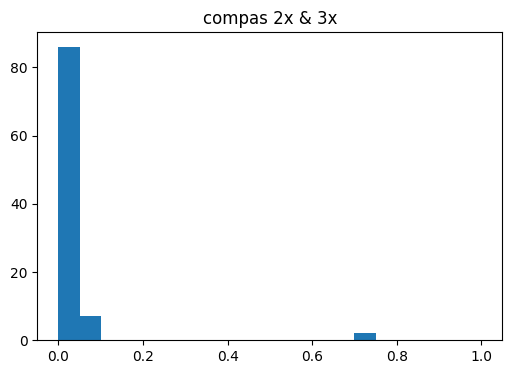

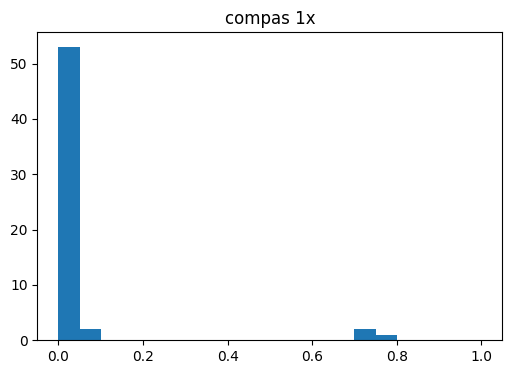

In [ ]:
MERGE_RMSD_HIST = {
    "compas-1x.csv_matched.csv_rmsd.csv": "compas 1x",
    "compas-2x.csv_matched.csv_rmsd.csv": "compas 2x & 3x",
    "compas-3x.csv_matched.csv_rmsd.csv": "compas 2x & 3x",
}

rmsd_hist = {}

for filepath in TMP_DIR.glob("*_rmsd.csv"):
    if filepath.name.count("_rmsd.csv") > 1:
        raise Exception("Something wrong. There is more than one `_matched.csv`.")
    if filepath.name not in MERGE_RMSD_HIST:
        continue
    merged_name = MERGE_RMSD_HIST[filepath.name]
    rmsd_hist[merged_name] = rmsd_hist.get(merged_name, [])
    compas_rmsd_data = pd.read_csv(filepath)
    for rmsd_xtb2 in compas_rmsd_data.rmsd_xtb2:
        rmsd_hist[merged_name].append(rmsd_xtb2)

for rmsd_hist_key in rmsd_hist:
    plt.figure(figsize=(6, 4))
    plt.title(rmsd_hist_key)
    plt.hist(rmsd_hist[rmsd_hist_key], bins=np.arange(0, 1 + 1e-10, 0.05))